check the generated paths to see if they share any nodes in common that they shouldnt

In [1]:
import pandas as pd
from collections import defaultdict
from collections import Counter

import seaborn as sns

from tqdm import tqdm

In [2]:
%matplotlib inline

## read the walks generated

In [3]:
walks = []

with open("/home/tongli/walks.txt", "r") as fin:
    for line in fin:
        vals = list(map(int, line.rstrip("\n").split(" ")))
        
        walks.append(vals)

## read nodes

In [4]:
nodes = pd.read_csv("data/min_hetionet/minhet_nodes.tsv", sep='\t')

In [5]:
nodes.head()

,node_uid,node_id,name,het_type
0,0,10,NAT2,Gene
1,1,100,ADA,Gene
2,2,10000,AKT3,Gene
3,3,10005,ACOT8,Gene
4,4,10007,GNPDA1,Gene


In [6]:
nodes.shape

(7927, 4)

## Total paths:

In [7]:
len(nodes) * 40

317080

In [8]:
len(walks)

317080

## check how many unique nodes each path visits

In [9]:
temp = defaultdict(list)
for walk in walks:
    start_node = walk[0]
    n_uniq = len(set(walk))
    
    temp["start_node"].append(start_node)
    temp["num_uniq_visited"].append(n_uniq)
    
uniq_nodes = pd.DataFrame(temp)

In [10]:
uniq_nodes.shape

(317080, 2)

In [11]:
uniq_nodes.head()

,num_uniq_visited,start_node
0,38,7376
1,38,5103
2,34,257
3,35,235
4,38,5757


---

In [12]:
uniq_nodes["start_node"].nunique()

7926

one node is missing from the embedding. strange, should be exact match

In [13]:
uniq_nodes.groupby("start_node").size().value_counts()

40    7886
41      40
dtype: int64

the algorithm generated 41 walks for 40 starting nodes instead of 40? strange

In [14]:
nodes.head()

,node_uid,node_id,name,het_type
0,0,10,NAT2,Gene
1,1,100,ADA,Gene
2,2,10000,AKT3,Gene
3,3,10005,ACOT8,Gene
4,4,10007,GNPDA1,Gene


In [15]:
uniq_nodes = uniq_nodes.merge(nodes, how="inner", left_on="start_node", right_on="node_uid")

In [16]:
uniq_nodes.head()

,num_uniq_visited,start_node,node_uid,node_id,name,het_type
0,38,7376,7376,DB08987,Etidocaine,Compound
1,36,7376,7376,DB08987,Etidocaine,Compound
2,36,7376,7376,DB08987,Etidocaine,Compound
3,37,7376,7376,DB08987,Etidocaine,Compound
4,35,7376,7376,DB08987,Etidocaine,Compound


In [17]:
uniq_nodes = uniq_nodes.drop("node_uid", axis=1)

In [18]:
uniq_nodes.head()

,num_uniq_visited,start_node,node_id,name,het_type
0,38,7376,DB08987,Etidocaine,Compound
1,36,7376,DB08987,Etidocaine,Compound
2,36,7376,DB08987,Etidocaine,Compound
3,37,7376,DB08987,Etidocaine,Compound
4,35,7376,DB08987,Etidocaine,Compound


In [19]:
uniq_nodes.query("start_node == 0")

,num_uniq_visited,start_node,node_id,name,het_type


got no walks for node 0. was it a completely disjoint node? seems like an error here but will check on later

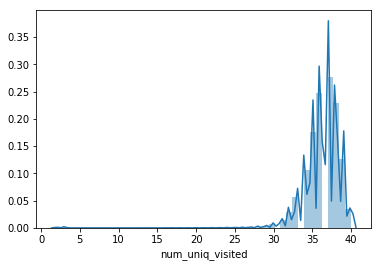

In [20]:
sns.distplot(uniq_nodes["num_uniq_visited"])

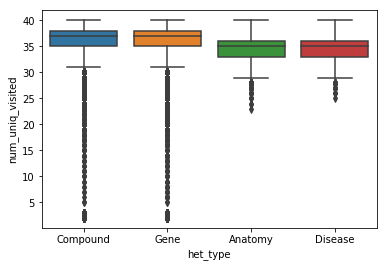

In [21]:
sns.boxplot(data=uniq_nodes, x="het_type", y="num_uniq_visited")

the anatomy and disease nodes seem to have fewer unique visited nodes per walk (less connected network likely)

---

## what node types get walked for each path?

In [22]:
mapper = {}
for idx, row in nodes.iterrows():
    mapper[row["node_uid"]] = row["het_type"]

In [23]:
def helper(walk):
    return Counter([mapper[node] for node in walk])

temp = defaultdict(list)

for walk in tqdm(walks):
    res = helper(walk)
    
    start_node = walk[0]
    
    temp[start_node].append(res)

100%|██████████| 317080/317080 [00:05<00:00, 59461.49it/s]


## Check that the nodes walked in a path are the correct kind

In [24]:
for key, val in temp.items():
    
    node_type = mapper[key]
    
    all_vis = set()
    for i in val:
        visited = set(i.keys())
        
        all_vis |= visited
    
    if node_type == 'Gene' or node_type == 'Compound':
        assert all_vis.isdisjoint({"Disease", "Anatomy"})
    else:
        assert node_type == 'Disease' or node_type == "Anatomy"
        
        assert all_vis.isdisjoint({"Gene", "Compound"})